
# SN-X3


In [1]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table,join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import treecorr
#import arviz as az
#import pandas as pd
#import pymc as pm
%matplotlib inline

import halomod as hm
import hmf

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import NoExclusion


In [2]:
import package.subsample 
import package.subsample_analysis 
import package.correlation_function 
import package.cosmology
import package.bias_calculator

In [3]:

home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')



# My catalog
fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits")  
t= Table.read(fits_file_path)
masked = os.path.join(thesis_path, "SN-X3_masked_cat.fits")  

t3= Table.read(masked)


t=join(t,t3,keys='id') # joined table
t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')



#Randoms
fits_random = os.path.join(thesis_path, "SN-X3_randoms_ugriz_trim_video.fits") 
hdulist = fits.open(fits_random)
hdulist.info()
t2= Table.read(fits_random)
randoms = t2

config = {
    'min_sep':  0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'bootstrap'  # or 'jackknife'
}

Filename: /home/astro/manasoi7/Master_Thesis/DATA/SN-X3_randoms_ugriz_trim_video.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SN-X3_C06_randoms_raw.fits    1 BinTableHDU     18   12972971R x 3C   [E, E, 9A]   


In [4]:
# My directories
directory_SN_X3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-X3"
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3"
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 
directory_COSMOS = "/home/astro/manasoi7/Master_Thesis/Results/COSMOS" 

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


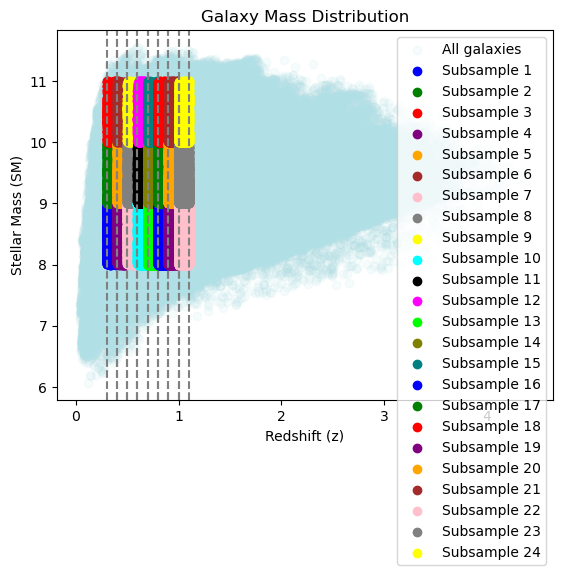

Subsample 1: N = 3488
  z_mean: 0.35
  SM_mean: 8.5
  z_min: 0.3

Subsample 2: N = 2687
  z_mean: 0.35
  SM_mean: 9.5
  z_min: 0.3

Subsample 3: N = 1466
  z_mean: 0.35
  SM_mean: 10.5
  z_min: 0.3

Subsample 4: N = 4659
  z_mean: 0.45
  SM_mean: 8.5
  z_min: 0.4

Subsample 5: N = 3157
  z_mean: 0.45
  SM_mean: 9.5
  z_min: 0.4

Subsample 6: N = 1688
  z_mean: 0.45
  SM_mean: 10.5
  z_min: 0.4

Subsample 7: N = 5684
  z_mean: 0.55
  SM_mean: 8.5
  z_min: 0.5

Subsample 8: N = 3280
  z_mean: 0.55
  SM_mean: 9.5
  z_min: 0.5

Subsample 9: N = 1731
  z_mean: 0.55
  SM_mean: 10.5
  z_min: 0.5

Subsample 10: N = 7877
  z_mean: 0.6499999999999999
  SM_mean: 8.5
  z_min: 0.6

Subsample 11: N = 3961
  z_mean: 0.6499999999999999
  SM_mean: 9.5
  z_min: 0.6

Subsample 12: N = 1995
  z_mean: 0.6499999999999999
  SM_mean: 10.5
  z_min: 0.6

Subsample 13: N = 11974
  z_mean: 0.75
  SM_mean: 8.5
  z_min: 0.7

Subsample 14: N = 4355
  z_mean: 0.75
  SM_mean: 9.5
  z_min: 0.7

Subsample 15: N = 2541
 

In [5]:
    
# Define z and SM ranges
z_values = np.array([ 0.3,0.4,0.5,0.6,0.7,0.8, 0.9,1.0, 1.1])  ### be careful about completness issues, maybe stop at 0.4 for high SM

#SM_range = np.linspace(9.5, 11, num=2) # High SM

#SM_range = np.linspace(8, 9.5, num=2) #Low SM
SM_range = np.linspace(8, 11, num=4) # diff SM



# Create subsamples
subsamples = []
z_mean_range = []
SM_mean_range = []

for i in range(len(z_values) - 1):
    z_min = z_values[i]
    z_max = z_values[i + 1]
    z_mean = (z_min + z_max) / 2
    z_mean_range.append(z_mean)

    for j in range(len(SM_range) - 1):
        SM_min = SM_range[j]
        SM_max = SM_range[j + 1]
        SM_mean = (SM_min + SM_max) / 2
        SM_mean_range.append(SM_mean)

        subsample = package.subsample.Subsample(z_min, z_max, SM_min, SM_max)
        
        subsample.info['z_mean'] = z_mean  # Add z_mean to the info dictionary
        subsample.info['z_min'] = z_min 
        subsample.info['SM_mean'] = SM_mean  # Add SM_mean to the info dictionary
        subsample.info['delta_z'] = (z_max - z_min)  # Assuming delta_z is the redshift bin width
        subsamples.append(subsample)


        
        
plt.scatter(t['z'], t['SM'], label='All galaxies',color='powderblue',alpha=0.1)

# Scatter plot with subsample colors
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'yellow', 'cyan', 'black', 'magenta', 'lime', 'olive', 'teal']
num_colors = len(colors)


for i, subsample in enumerate(subsamples):
    subset = subsample.apply(t)
    z_subsample = t['z'][subset]
    SM_subsample = t['SM'][subset]

    plt.scatter(z_subsample, SM_subsample, label=f'Subsample {i+1}', c=colors[i % num_colors])

for i in range(len(z_values) - 1):
    z_min = z_values[i]
    z_max = z_values[i + 1]
    plt.axvline(z_min, linestyle='--', color='gray')
    plt.axvline(z_max, linestyle='--', color='gray')

plt.xlabel('Redshift (z)')
plt.ylabel('Stellar Mass (SM)')
plt.title('Galaxy Mass Distribution')
plt.legend()
plt.show()

# Create SkyCoord catalogs for subsamples
catalogs = []

for subsample in subsamples:
    subset = subsample.apply(t)
    catalog = t[subset]
    #catalog = SkyCoord(ra=ra_subset * u.deg, dec=dec_subset * u.deg)
    
    catalogs.append(catalog)

# Print number of galaxies in each subsample
for i, subsample in enumerate(subsamples):
    N = len(catalogs[i])

    print(f"Subsample {i+1}: N = {N}")
    print(f"  z_mean: {subsample.info['z_mean']}")
    print(f"  SM_mean: {subsample.info['SM_mean']}")
    print(f"  z_min: {subsample.info['z_min']}")
    print()

In [6]:
# Create CorrelationFunction objects with the same configuration
corr_funcs = []

for i, catalog in enumerate(catalogs):


    corr_func = package.correlation_function.CorrelationFunction(catalog, randoms, config)
    corr_func.process()
    w, varw, theta, rr = corr_func.calculate_w_theta()

    # Append the calculated values to the corresponding subsample's info dictionary
    subsamples[i].info['w'] = w
    subsamples[i].info['varw'] = varw
    subsamples[i].info['theta'] = theta
    subsamples[i].info['rr'] = rr
    corr_funcs.append(corr_func)

Subsample 1, Power-law Fit Parameters
 Amplitude at 1°: 0.004534429387167796
 Delta: -0.5787206713516186

Subsample 2, Power-law Fit Parameters
 Amplitude at 1°: 0.008548785237552045
 Delta: -0.7350110831915379

Subsample 3, Power-law Fit Parameters
 Amplitude at 1°: 0.004912029692816702
 Delta: -0.9096166203251733

Subsample 4, Power-law Fit Parameters
 Amplitude at 1°: 0.0016875857990388576
 Delta: -0.8778420272178469

Subsample 5, Power-law Fit Parameters
 Amplitude at 1°: 0.007925295832749655
 Delta: -0.7139365798159331

Subsample 6, Power-law Fit Parameters
 Amplitude at 1°: 0.003938758551710475
 Delta: -0.949453862240569

Subsample 7, Power-law Fit Parameters
 Amplitude at 1°: 0.004161363817078498
 Delta: -0.5146360672007286

Subsample 8, Power-law Fit Parameters
 Amplitude at 1°: 0.01308192240771882
 Delta: -0.5583664252464964

Subsample 9, Power-law Fit Parameters
 Amplitude at 1°: 9.063077798767331e-06
 Delta: -2.050121624674253

Subsample 10, Power-law Fit Parameters
 Amplitu

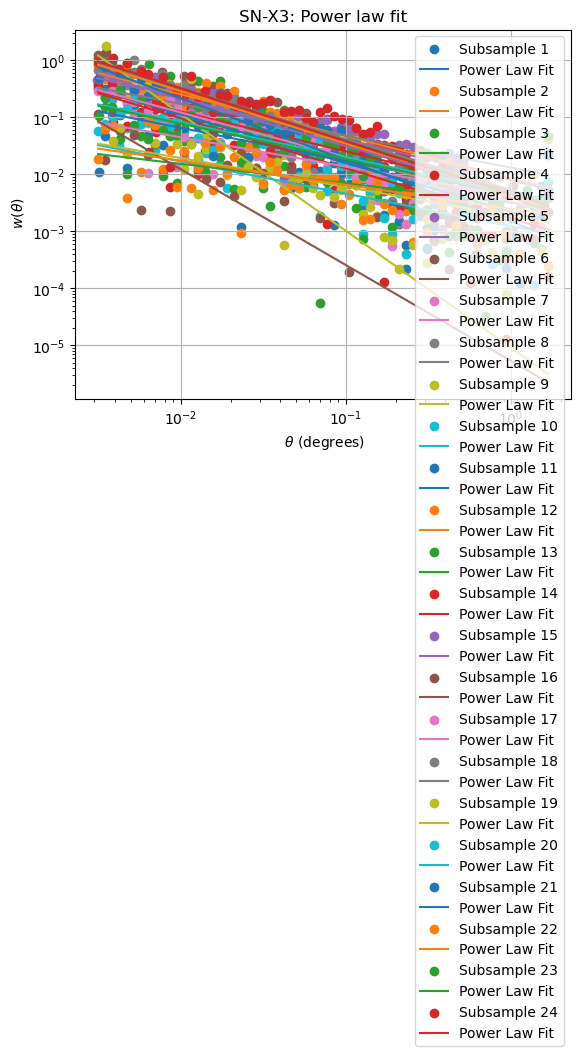

In [7]:
def power_law(theta, A, delta):
    return A * theta**delta


def fit_and_plot_power_law(theta, w, cat):
    """
    Fits a power law to the provided 2PCF data and plots the results.

    Args:
        theta (np.ndarray): Angular separation bins.
        w (np.ndarray): 2PCF values for the current catalog.
        cat (int): Identifier for the current catalog (used for labeling).
    """

    # Fit the power law using curve_fit with initial guesses
    popt, pcov = curve_fit(power_law, subsample.info['theta'], subsample.info['w'], p0=[2e-2, -0.8])

    # Extract fitted parameters
    A_fit = popt[0]
    delta_fit = popt[1]

    # Calculate amplitude at 1 degree
    amplitude_at_1deg = power_law(1, A_fit, delta_fit)

    # Print fit parameters
    print(f"Subsample {cat}, Power-law Fit Parameters")
    print(f" Amplitude at 1°:", amplitude_at_1deg)
    print(f" Delta:", delta_fit)
    print()

    # Plot the data and fitted curve for this catalog
    plt.scatter(subsample.info['theta'], subsample.info['w'], label=f"Subsample {cat}")
    plt.plot(subsample.info['theta'], power_law(subsample.info['theta'], *popt), label='Power Law Fit')


    return amplitude_at_1deg, delta_fit


for i, subsample in enumerate(subsamples):
 
    A, delta = fit_and_plot_power_law(subsamples[i].info['theta'][i], subsamples[i].info['w'], i + 1)
    subsamples[i].info['A'] = A
    subsamples[i].info['delta'] = delta

plt.title("SN-X3: Power law fit")
plt.xlabel(r' $ \theta$ (degrees)')
plt.ylabel(r' $w(\theta)$')
plt.yscale('log')
plt.xscale('log')
plt.savefig(os.path.join(directory_SN_X3, "r0_vs_z_for_diff_SM_SN-X3.png"))
plt.grid(True)
plt.legend()
plt.show()

In [8]:
r0_values = []
for subsample in subsamples:
    # Create a SubsampleAnalysis object with relevant information
    analysis = package.subsample_analysis.SubsampleAnalysis(subsample.info['delta'], subsample.info['A'],
                                  subsample.info['z_mean'], subsample.info['delta_z'] ,3.68, 299792.458) # H_gamma=3.68, c=299792.458

    # Calculate R_0 for the subsample
    r0 = analysis.calculate_r0()

    r0_values.append(r0)
    

<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8
<class 'numpy.float64'>
1.8


In [9]:
m = np.unique(SM_mean_range) # Get the unique SM values
z= z_mean_range

print('len(m):',len(m))
print('len(z):',len(z))

zm=np.meshgrid(m,z)
np.array(zm)
zm=np.array(zm).reshape(2,-1)
zm[:,0]

r0s_reshaped = np.reshape(r0_values, (len(z), len(m))).T  # since r0s is a flattened array


len(m): 3
len(z): 8


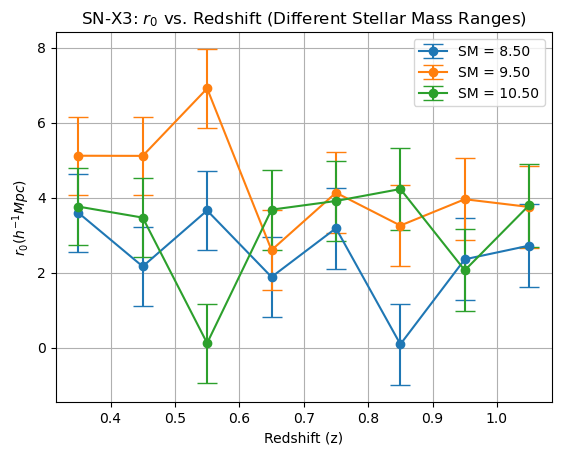

In [10]:
for i in range(len(m)):
    sigma = [0.1 * z_mean + 1 for z_mean in z]  # is the rms error on each redshift
    plt.errorbar(z, r0s_reshaped[i], yerr=sigma, label=f"SM = {m[i]:.2f}",marker='o',capsize=7)

plt.xlabel("Redshift (z)")
plt.ylabel(r"$r_0 (h^{-1} Mpc)$")
plt.title(r"SN-X3: $r_0$ vs. Redshift (Different Stellar Mass Ranges)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(directory_SN_X3, "r0_vs_z_for_diff_SM_SN-X3.png"))

plt.show()

In [11]:

nz = hm.integrate_corr.flat_z_dist(np.min(z_values), np.max(z_values))
gg = hm.integrate_corr.AngularCF(nz,nz,p_of_z=True,zmin=np.min(z_values),zmax=np.max(z_values),z=np.mean(z_values))
gg.hod_params = {"M_min":13.27, "M_1": 14.6, "alpha":1.}
#gg.theta_min = np.min(thetas[0])*np.pi/180
#gg.theta_max = np.max(thetas[0])*np.pi/180
#gg.theta_num = len(thetas[0])

gg.theta_min = np.min(subsample.info['theta'][0])*np.pi/180
gg.theta_max = np.max(subsample.info['theta'][0])*np.pi/180

print(gg.angular_corr_gal)

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


[0.85021677 0.85021677 0.85021677 0.85021677 0.85021677 0.85021677
 0.85021677 0.85021677 0.85021677 0.85021677 0.85021677 0.85021677
 0.85021677 0.85021677 0.85021677 0.85021677 0.85021677 0.85021677
 0.85021677 0.85021677 0.85021677 0.85021677 0.85021677 0.85021677
 0.85021677 0.85021677 0.85021677 0.85021677 0.85021677 0.85021677]


In [12]:
import package.bias_calculator


In [13]:

# wobs(theta)= b**2 * wdm(theta)
def w_model(wdm, b):
    return wdm*(b**2)


In [14]:
for i, subsample in enumerate(subsamples):
    print(f"Subsample {i+1} z_mean: {subsample.info['z_mean']:.3f}")
    print(f" A: {subsample.info['A']:.3f}")
    print(f" delta: {subsample.info['delta']:.3f}")
    print()

    

Subsample 1 z_mean: 0.350
 A: 0.005
 delta: -0.579

Subsample 2 z_mean: 0.350
 A: 0.009
 delta: -0.735

Subsample 3 z_mean: 0.350
 A: 0.005
 delta: -0.910

Subsample 4 z_mean: 0.450
 A: 0.002
 delta: -0.878

Subsample 5 z_mean: 0.450
 A: 0.008
 delta: -0.714

Subsample 6 z_mean: 0.450
 A: 0.004
 delta: -0.949

Subsample 7 z_mean: 0.550
 A: 0.004
 delta: -0.515

Subsample 8 z_mean: 0.550
 A: 0.013
 delta: -0.558

Subsample 9 z_mean: 0.550
 A: 0.000
 delta: -2.050

Subsample 10 z_mean: 0.650
 A: 0.001
 delta: -0.567

Subsample 11 z_mean: 0.650
 A: 0.002
 delta: -0.853

Subsample 12 z_mean: 0.650
 A: 0.004
 delta: -0.921

Subsample 13 z_mean: 0.750
 A: 0.003
 delta: -0.342

Subsample 14 z_mean: 0.750
 A: 0.005
 delta: -0.698

Subsample 15 z_mean: 0.750
 A: 0.005
 delta: -0.834

Subsample 16 z_mean: 0.850
 A: 0.000
 delta: -1.681

Subsample 17 z_mean: 0.850
 A: 0.003
 delta: -0.782

Subsample 18 z_mean: 0.850
 A: 0.005
 delta: -0.894

Subsample 19 z_mean: 0.950
 A: 0.002
 delta: -0.506

Su

In [15]:
sm_biases = []

for i, subsample in enumerate(subsamples):

    calculator = package.bias_calculator.BiasCalculator(w_model, gg)

    # Calculate bias and error for the subsample
    bias, bias_error, popt, pcov = calculator.calculate_bias(subsample.info['w'])

    # Print and store results
    print(f"Subsample {i+1} SM_mean: {subsample.info['SM_mean']:.3f}")
    print(f"Bias: {bias:.3f} +/- {bias_error:.3f}")
    print()

    sm_biases.append([subsample.info['SM_mean'], bias, bias_error])



/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:784: UserWarning: You are using an un-normalized mass function and bias function pair.Bias Tinker10 has the following paired HMF model: (). Matter correlations are not well-defined.
  tools.norm_warn(self)


Subsample 1 SM_mean: 8.500
Bias: 0.908 +/- 0.129

Subsample 2 SM_mean: 9.500
Bias: 1.790 +/- 0.109

Subsample 3 SM_mean: 10.500
Bias: 2.075 +/- 0.188

Subsample 4 SM_mean: 8.500
Bias: 1.122 +/- 0.093

Subsample 5 SM_mean: 9.500
Bias: 1.641 +/- 0.111

Subsample 6 SM_mean: 10.500
Bias: 2.062 +/- 0.189

Subsample 7 SM_mean: 8.500
Bias: 0.754 +/- 0.115

Subsample 8 SM_mean: 9.500
Bias: 1.472 +/- 0.094

Subsample 9 SM_mean: 10.500
Bias: 1.741 +/- 0.249

Subsample 10 SM_mean: 8.500
Bias: 0.459 +/- 0.084

Subsample 11 SM_mean: 9.500
Bias: 1.219 +/- 0.098

Subsample 12 SM_mean: 10.500
Bias: 1.955 +/- 0.147

Subsample 13 SM_mean: 8.500
Bias: 0.449 +/- 0.106

Subsample 14 SM_mean: 9.500
Bias: 1.255 +/- 0.090

Subsample 15 SM_mean: 10.500
Bias: 1.632 +/- 0.134

Subsample 16 SM_mean: 8.500
Bias: 0.542 +/- 0.065

Subsample 17 SM_mean: 9.500
Bias: 1.239 +/- 0.079

Subsample 18 SM_mean: 10.500
Bias: 2.041 +/- 0.157

Subsample 19 SM_mean: 8.500
Bias: 0.492 +/- 0.060

Subsample 20 SM_mean: 9.500
Bias: 

In [16]:


# Create a NumPy array from the list of lists (modified for 3 columns)
sm_biases_array = np.array(sm_biases)

# Construct the full file path
file_path = os.path.join(directory_SN_X3, "sm_biases.txt")

# Save the array using delimiter for each column (modified for 3 columns)
np.savetxt(file_path, sm_biases_array, delimiter=',', fmt='%.3f')


# Load the data from the text file
SN_X3 = np.loadtxt(file_path, delimiter=',')

# Extract SM_mean, bias, and error values from the loaded data
sm_means = SN_X3[:, 0]
sm_biases = SN_X3[:, 1]
sm_biases_errors = SN_X3[:, 2]

In [17]:
sm_biases_reshaped = np.reshape(sm_biases, (len(z), len(m))).T  


In [18]:

for i in range(len(m)):
    print(sm_biases_reshaped[i])



[0.908 1.122 0.754 0.459 0.449 0.542 0.492 0.476]
[1.79  1.641 1.472 1.219 1.255 1.239 1.022 0.981]
[2.075 2.062 1.741 1.955 1.632 2.041 1.729 2.073]


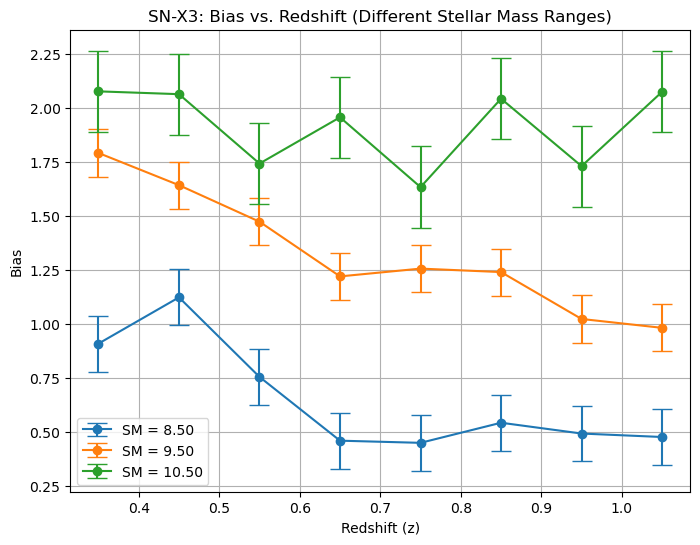

In [19]:
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

for i in range(len(m)):
    plt.errorbar(z, sm_biases_reshaped[i],yerr= sm_biases_errors[i],label=f"SM = {m[i]:.2f}",marker='o',capsize=7)
    #plt.plot(redshifts, E2[:, 1][i], label=f"SM = {m[i]:.2f}",marker='o')
    #plt.plot(redshifts, X3[:, 1][:, 1][i], label=f"SM = {m[i]:.2f}",marker='o')
plt.xlabel("Redshift (z)")
plt.ylabel(r"Bias")
plt.title(r"SN-X3: Bias vs. Redshift (Different Stellar Mass Ranges)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(directory_SN_X3, "Bias_vs_z_for_diff_SM_SN-X3.png"))

plt.show()

In [20]:
"""plt.figure(figsize=(8, 6))  # Adjust figure size as needed

# Extract bias and redshift values
redshifts = [subsample.info['z_mean'] for subsample in subsamples]

# Plot bias vs. redshift
#plt.errorbar(redshifts, L_biases, label='Low Stellar Mass ',marker='o') # 8 to 9.5
#plt.errorbar(redshifts, H_biases, label='High Stellar Mass',marker='o') #9.5 to 11
plt.errorbar(redshifts, sm_biases, yerr=sm_biases_errors, label='Different Stellar Masses',marker='o',capsize=7,)
#plt.errorbar(redshifts, high_biases, yerr= high_errors, label='High Stellar Masses',marker='o',capsize=7,)

plt.xlabel("Redshift (z)")
plt.ylabel("Bias")
plt.title("Bias as a Function of Redshift")

plt.savefig(os.path.join(directory_SN_X3,"Bias as a Function of Redshift for High SM"))

# Customize plot (optional)
plt.grid(True)
plt.legend()
plt.show()"""

'plt.figure(figsize=(8, 6))  # Adjust figure size as needed\n\n# Extract bias and redshift values\nredshifts = [subsample.info[\'z_mean\'] for subsample in subsamples]\n\n# Plot bias vs. redshift\n#plt.errorbar(redshifts, L_biases, label=\'Low Stellar Mass \',marker=\'o\') # 8 to 9.5\n#plt.errorbar(redshifts, H_biases, label=\'High Stellar Mass\',marker=\'o\') #9.5 to 11\nplt.errorbar(redshifts, sm_biases, yerr=sm_biases_errors, label=\'Different Stellar Masses\',marker=\'o\',capsize=7,)\n#plt.errorbar(redshifts, high_biases, yerr= high_errors, label=\'High Stellar Masses\',marker=\'o\',capsize=7,)\n\nplt.xlabel("Redshift (z)")\nplt.ylabel("Bias")\nplt.title("Bias as a Function of Redshift")\n\nplt.savefig(os.path.join(directory_SN_X3,"Bias as a Function of Redshift for High SM"))\n\n# Customize plot (optional)\nplt.grid(True)\nplt.legend()\nplt.show()'

In [21]:

# Define the directory where you want to save the file
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 

In [22]:
# Construct the full file path
f = os.path.join(directory_SN_E2, "high_sm_biases.txt")

# Load the data from the text file
E2 = np.loadtxt(f, delimiter=',')

In [23]:
ss = E2[:, 0]
high_b = E2[:, 1]
high_e = E2[:, 2]

In [24]:
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

# Extract bias and redshift values
redshifts = [subsample.info['z_mean'] for subsample in subsamples]

# Plot bias vs. redshift

#plt.errorbar(redshifts, L_biases, label='Low Stellar Mass ',marker='o') # 8 to 9.5
#plt.errorbar(redshifts, H_biases, label='High Stellar Mass',marker='o') #9.5 to 11
#plt.scatter(redshifts, diff_biases, label='Different Stellar Masses',marker='o')
plt.plot(redshifts, high_biases, label='X3',marker='o')
plt.plot(redshifts, high_b, label='E2',marker='o')


plt.xlabel("Redshift (z)")
plt.ylabel("Bias")
plt.title("Bias as a Function of Redshift")

plt.savefig(os.path.join(directory_SN_X3,"Bias as a Function of Redshift for High SM"))

# Customize plot (optional)
plt.grid(True)
plt.legend()
plt.show()

NameError: name 'high_biases' is not defined

In [ ]:
c = os.path.join(directory_SN_C3, "subsamples_info_SN-C3.txt")




# Load the data from the text file
C3 = np.loadtxt(c, delimiter=',')

In [ ]:
# Create the plot
plt.figure(figsize=(8, 6))  # Set plot size

plt.plot(redshifts, C3[:, 2], label='C3', marker='o')
#plt.plot(redshifts, high_biases, label='X3',marker='o')
plt.plot(redshifts, high_b, label='E2',marker='o')

# Customize the plot
plt.xlabel('Redshift (z)')
plt.ylabel('Bias')
plt.title('Bias vs. Redshift (Sample Data)')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()